## Demo Integrada: Sistema de Optimización de Rutas y Efectivo para Cajeros Automáticos
 
Construcción del paso a paso: desde el análisis de datos, pasando por la predicción de demanda, hasta la optimización de rutas. El resultado es una solución integral que busca hacer más eficiente la operación de los cajeros automáticos en Bogotá.
 
### Objetivos de la DEMO
 
- **Optimizar la operación del centro de efectivo**, asegurando disponibilidad de efectivo en cajeros
- **Reducir costos logísticos** mediante rutas eficientes y planificación inteligente
- **Aumentar la precisión de pronósticos** a más del 87%
- **Reducir el downtime por agotamiento** a menos del 15%
- **Mejorar la eficiencia operativa** mediante decisiones basadas en datos

### 1.Configuración Inicial y carga de datos

In [1]:
# Importar bibliotecas necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.ticker import EngFormatter
import seaborn as sns
from sqlalchemy import create_engine, text
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster, AntPath
import os
from dotenv import load_dotenv
import warnings
from datetime import datetime, timedelta
import random
import math
from IPython.display import display, HTML
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

# Ignorar advertencias para una visualización más limpia
warnings.filterwarnings('ignore')

# Configuración para visualización
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_style('whitegrid')
%matplotlib inline

# Configurar colores y estilo consistente
colors = {
    'primary': '#4e73df',
    'success': '#1cc88a',
    'info': '#36b9cc',
    'warning': '#f6c23e',
    'danger': '#e74a3b',
    'secondary': '#858796',
    'light': '#f8f9fc',
    'dark': '#5a5c69',
}

load c:\Users\tanat\OneDrive\Documentos\Stefanini\Proyectos\aval_valor_compartido\atm-route-optimizer-demo\venv\Lib\site-packages\ortools\.libs\zlib1.dll...
load c:\Users\tanat\OneDrive\Documentos\Stefanini\Proyectos\aval_valor_compartido\atm-route-optimizer-demo\venv\Lib\site-packages\ortools\.libs\abseil_dll.dll...
load c:\Users\tanat\OneDrive\Documentos\Stefanini\Proyectos\aval_valor_compartido\atm-route-optimizer-demo\venv\Lib\site-packages\ortools\.libs\utf8_validity.dll...
load c:\Users\tanat\OneDrive\Documentos\Stefanini\Proyectos\aval_valor_compartido\atm-route-optimizer-demo\venv\Lib\site-packages\ortools\.libs\re2.dll...
load c:\Users\tanat\OneDrive\Documentos\Stefanini\Proyectos\aval_valor_compartido\atm-route-optimizer-demo\venv\Lib\site-packages\ortools\.libs\libprotobuf.dll...
load c:\Users\tanat\OneDrive\Documentos\Stefanini\Proyectos\aval_valor_compartido\atm-route-optimizer-demo\venv\Lib\site-packages\ortools\.libs\highs.dll...
load c:\Users\tanat\OneDrive\Documentos\S

In [2]:
# Cargar variables de entorno desde el archivo .env
load_dotenv()

# Obtener los valores del archivo .env
db_user = os.getenv('DB_USER', 'postgres')
db_password = os.getenv('DB_PASSWORD', 'yourpassword')
db_host = os.getenv('DB_HOST', 'localhost')
db_port = os.getenv('DB_PORT', '5432')
db_name = os.getenv('DB_NAME', 'atm_optimizer')

# Cadena de conexión para SQLAlchemy
conn_string = f'postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}'
engine = create_engine(conn_string)

print(f"Conectado a: {db_name} en {db_host}")


Conectado a: atm_optimization en localhost


### Información  usada para la DEMO

In [3]:
# Función para cargar datos consolidados
def load_atm_data():
    """Carga todos los datos necesarios para la optimización de cajeros"""
    try:
        # Cargar datos de cajeros
        query_atms = """
        SELECT id, name, 
               ST_X(location::geometry) as longitude, 
               ST_Y(location::geometry) as latitude,
               capacity, cash_type, location_type, 
               min_threshold, max_capacity
        FROM atms;
        """
        atms_df = pd.read_sql(query_atms, engine)
        print(f"Cajeros cargados: {len(atms_df)}")
        
        # Cargar datos de transportadoras
        query_carriers = """
        SELECT id, name, 
               ST_X(base_location::geometry) as base_longitude, 
               ST_Y(base_location::geometry) as base_latitude,
               capacity, vehicles, service_area
        FROM carriers;
        """
        carriers_df = pd.read_sql(query_carriers, engine)
        print(f"Transportadoras cargadas: {len(carriers_df)}")
        
        # Cargar restricciones
        query_restrictions_2 = """
        SELECT DISTINCT notes as Cantidad_Restricciones FROM restrictions;
        """
        restrictions_df_2 = pd.read_sql(query_restrictions_2, engine)
        print(f"Cantidad de restricciones cargadas: {len(restrictions_df_2)}")
        
        query_restrictions = """
            SELECT atm_id, day_of_week, open_time, close_time, restock_allowed
            FROM restrictions;
            """
        restrictions_df = pd.read_sql(query_restrictions, engine)
        
        # Cargar transacciones
        try:
            query_transactions = """
            SELECT COUNT(*) as total FROM transactions;
            """
            total_transactions = pd.read_sql(query_transactions, engine).iloc[0]['total']
            
            # Cargar una muestra para saber el rango de fechas
            query_transactions_range = """
            SELECT MIN(transaction_date) as min_date, 
                   MAX(transaction_date) as max_date 
            FROM transactions;
            """
            date_range = pd.read_sql(query_transactions_range, engine)
            
            print(f"Transacciones cargadas: {total_transactions:,} registros")
            if not date_range.empty and pd.notna(date_range['min_date'].iloc[0]) and pd.notna(date_range['max_date'].iloc[0]):
                print(f"Rango de fechas: {date_range['min_date'].iloc[0]} a {date_range['max_date'].iloc[0]}")
            
            # No necesitamos devolver todas las transacciones, ya que podrían ser muchas
            transactions_df = None
        except Exception as e:
            print(f"No se encontraron transacciones o error al cargarlas: {e}")
            total_transactions = 0
        
        return atms_df, carriers_df, restrictions_df
    
    except Exception as e:
        print(f"Error al cargar datos: {e}")
        print("Utilizando datos de ejemplo...")
        
        # Crear datos de ejemplo si falla la carga
        # [Resto del código igual...]

        return atms_df, carriers_df, restrictions_df

# Cargar todos los datos
atms_df, carriers_df, restrictions_df = load_atm_data()


Cajeros cargados: 100
Transportadoras cargadas: 5
Cantidad de restricciones cargadas: 6
Transacciones cargadas: 75,000 registros
Rango de fechas: 2023-09-01 a 2024-03-01


### Analisis del estado actual

In [4]:
# Función para simular el estado actual de los cajeros
def simulate_current_atm_status(atms_df):
    """
    Simula el estado actual de los cajeros basado en datos históricos de consumo
    
    Returns:
        DataFrame con estado actual incluyendo:
        - Efectivo disponible
        - % de capacidad utilizada
        - Estado (Normal, Advertencia, Crítico)
    """
    # Copiar dataframe para no modificar el original
    status_df = atms_df.copy()
    
    # Simular efectivo disponible (entre 10% y 90% de capacidad)
    status_df['current_cash'] = status_df.apply(
        lambda row: max(0, row['capacity'] * random.uniform(0.1, 0.9)), 
        axis=1
    )
    
    # Calcular porcentaje de capacidad utilizada
    status_df['usage_percent'] = (status_df['current_cash'] / status_df['capacity'] * 100).round(2)
    
    # Determinar estado basado en umbral y capacidad actual
    status_df['status'] = status_df.apply(
        lambda row: 'Crítico' if row['current_cash'] < row['min_threshold'] else
                    'Advertencia' if row['current_cash'] < row['min_threshold'] * 1.5 else
                    'Normal',
        axis=1
    )
    
    # Simular último reabastecimiento (entre 1 y 14 días atrás)
    today = datetime.now().date()
    status_df['last_restock'] = status_df.apply(
        lambda row: (today - timedelta(days=random.randint(1, 14))).strftime('%Y-%m-%d'),
        axis=1
    )
    
    # Simular días estimados hasta agotamiento basado en consumo promedio
    # Consumo diario aproximado entre 3-10% de capacidad
    status_df['daily_consumption'] = status_df.apply(
        lambda row: row['capacity'] * random.uniform(0.03, 0.1),
        axis=1
    )
    
    # Calcular días hasta agotamiento
    status_df['days_until_empty'] = status_df.apply(
        lambda row: max(0, (row['current_cash'] - row['min_threshold']) / row['daily_consumption']),
        axis=1
    ).round(1)
    
    return status_df

# Obtener estado actual simulado
current_status = simulate_current_atm_status(atms_df)

# Mostrar resumen de estado
status_summary = current_status['status'].value_counts().reset_index()
status_summary.columns = ['Estado', 'Cantidad']

print("Resumen de estado actual de cajeros:")
display(status_summary)

# Mostrar detalles de cajeros en estado crítico
critical_atms = current_status[current_status['status'] == 'Crítico'].sort_values('days_until_empty')
if len(critical_atms) > 0:
    print("\nCajeros en estado crítico que requieren atención inmediata:")
    display(critical_atms[['id', 'name', 'current_cash', 'min_threshold', 'days_until_empty', 'last_restock']])
else:
    print("\nNo hay cajeros en estado crítico actualmente.")

Resumen de estado actual de cajeros:


,Estado,Cantidad
0,Normal,83
1,Advertencia,14
2,Crítico,3



Cajeros en estado crítico que requieren atención inmediata:


,id,name,current_cash,min_threshold,days_until_empty,last_restock
31,ATM032,Cajero Universidad Oeste,1.166382e+07,15362138.0,0.0,2025-04-22
63,ATM064,Cajero Estación Transmilenio Este,6.871463e+06,7708379.0,0.0,2025-04-15
97,ATM098,Cajero Banco Norte,1.450270e+07,18428848.0,0.0,2025-04-18


In [5]:
# Crear mapa de estado actual de cajeros
def create_status_map(status_df, carriers_df):
    """
    Crea un mapa interactivo mostrando el estado actual de los cajeros
    """
    # Crear mapa centrado en el promedio de coordenadas
    center_lat = status_df['latitude'].mean()
    center_lon = status_df['longitude'].mean()
    m = folium.Map(location=[center_lat, center_lon], zoom_start=12)
    
    # Añadir cajeros al mapa con colores según estado
    for _, row in status_df.iterrows():
        # Determinar color según estado
        if row['status'] == 'Crítico':
            color = 'red'
        elif row['status'] == 'Advertencia':
            color = 'orange'
        else:
            color = 'green'
        
        # Crear popup con información detallada
        popup_html = f"""
            <div style="width: 200px">
                <h4>{row['name']}</h4>
                <b>ID:</b> {row['id']}<br>
                <b>Tipo:</b> {row['location_type']}<br>
                <b>Efectivo:</b> ${row['current_cash']:,.0f}<br>
                <b>Capacidad:</b> {row['usage_percent']:.1f}%<br>
                <b>Último reabast.:</b> {row['last_restock']}<br>
                <b>Días hasta agotamiento:</b> {row['days_until_empty']:.1f}
            </div>
        """
        
        folium.Marker(
            location=[row['latitude'], row['longitude']],
            popup=folium.Popup(popup_html, max_width=250),
            tooltip=f"{row['name']} - {row['status']}",
            icon=folium.Icon(color=color, icon='money-bill-alt', prefix='fa')
        ).add_to(m)
    
    # Añadir transportadoras
    for _, row in carriers_df.iterrows():
        popup_html = f"""
            <div style="width: 200px">
                <h4>{row['name']}</h4>
                <b>ID:</b> {row['id']}<br>
                <b>Vehículos:</b> {row['vehicles']}<br>
                <b>Zona:</b> {row['service_area']}<br>
            </div>
        """
        
        folium.Marker(
            location=[row['base_latitude'], row['base_longitude']],
            popup=folium.Popup(popup_html, max_width=250),
            tooltip=f"Transportadora: {row['name']}",
            icon=folium.Icon(color='black', icon='truck', prefix='fa')
        ).add_to(m)
    
    return m

# Crear y mostrar mapa de estado actual
status_map = create_status_map(current_status, carriers_df)
display(status_map)

### Métricas 

In [6]:
# Calcular KPIs actuales
def calculate_current_kpis(status_df):
    """Calcula KPIs basados en el estado actual"""
    kpis = {}
    
    # KPI 1: Disponibilidad de efectivo (% de cajeros por encima del umbral mínimo)
    total_atms = len(status_df)
    atms_above_threshold = len(status_df[status_df['current_cash'] >= status_df['min_threshold']])
    kpis['disponibilidad'] = round((atms_above_threshold / total_atms * 100), 2)
    
    # KPI 2: Downtime por agotamiento (% de cajeros en estado crítico)
    critical_atms = len(status_df[status_df['status'] == 'Crítico'])
    kpis['downtime'] = round((critical_atms / total_atms * 100), 2)
    
    # KPI 3: Eficiencia de capital (% promedio de utilización de capacidad)
    kpis['eficiencia_capital'] = round(status_df['usage_percent'].mean(), 2)
    
    # KPI 4: Urgencia de reabastecimiento (días promedio hasta agotamiento)
    kpis['dias_hasta_agotamiento'] = round(status_df['days_until_empty'].mean(), 2)
    
    # KPI 5: Cajeros que requieren atención en los próximos 3 días
    require_attention_soon = len(status_df[status_df['days_until_empty'] <= 3])
    kpis['requieren_atencion_pronto'] = require_attention_soon
    
    return kpis

# Calcular y mostrar KPIs actuales
current_kpis = calculate_current_kpis(current_status)

# Crear tabla HTML estilizada para mostrar KPIs
html_kpis = """
<div style="display: flex; flex-wrap: wrap; gap: 10px; font-family: Arial, sans-serif;">
"""

# Definir los KPIs con iconos, colores y descripciones
kpi_data = [
    {
        'name': 'Disponibilidad de Efectivo', 
        'value': f"{current_kpis['disponibilidad']}%", 
        'icon': 'check-circle', 
        'color': '#1cc88a' if current_kpis['disponibilidad'] >= 85 else '#e74a3b',
        'target': '≥ 85%',
        'description': 'Porcentaje de cajeros con efectivo por encima del umbral mínimo'
    },
    {
        'name': 'Downtime por Agotamiento', 
        'value': f"{current_kpis['downtime']}%", 
        'icon': 'exclamation-triangle', 
        'color': '#1cc88a' if current_kpis['downtime'] <= 15 else '#e74a3b',
        'target': '≤ 15%',
        'description': 'Porcentaje de cajeros en estado crítico (sin efectivo disponible)'
    },
    {
        'name': 'Eficiencia de Capital', 
        'value': f"{current_kpis['eficiencia_capital']}%", 
        'icon': 'dollar-sign', 
        'color': '#1cc88a' if 40 <= current_kpis['eficiencia_capital'] <= 70 else '#e74a3b',
        'target': '40-70%',
        'description': 'Utilización promedio de la capacidad de los cajeros'
    },
    {
        'name': 'Días hasta Agotamiento', 
        'value': f"{current_kpis['dias_hasta_agotamiento']}", 
        'icon': 'calendar', 
        'color': '#1cc88a' if current_kpis['dias_hasta_agotamiento'] >= 5 else '#e74a3b',
        'target': '≥ 5 días',
        'description': 'Promedio de días hasta que los cajeros lleguen al umbral mínimo'
    },
    {
        'name': 'Requieren Atención Pronto', 
        'value': f"{current_kpis['requieren_atencion_pronto']}", 
        'icon': 'bell', 
        'color': '#1cc88a' if current_kpis['requieren_atencion_pronto'] <= len(current_status) * 0.2 else '#e74a3b',
        'target': f'≤ {int(len(current_status) * 0.2)}',
        'description': 'Número de cajeros que necesitarán reabastecimiento en los próximos 3 días'
    }
]

# Generar HTML para cada KPI
for kpi in kpi_data:
    html_kpis += f"""
    <div style="flex: 1; min-width: 200px; background-color: white; border-radius: 8px; 
                padding: 15px; box-shadow: 0 4px 6px rgba(0,0,0,0.1);">
        <div style="display: flex; align-items: center; margin-bottom: 10px;">
            <div style="width: 40px; height: 40px; border-radius: 50%; background-color: {kpi['color']}; 
                      display: flex; justify-content: center; align-items: center; margin-right: 10px;">
                <i class="fas fa-{kpi['icon']}" style="color: white; font-size: 18px;"></i>
            </div>
            <div>
                <div style="font-size: 12px; color: #888;">{kpi['name']}</div>
                <div style="font-size: 18px; font-weight: bold; color: {kpi['color']};">{kpi['value']}</div>
            </div>
        </div>
        <div style="font-size: 12px; color: #888; margin-bottom: 5px;">Objetivo: {kpi['target']}</div>
        <div style="font-size: 12px; color: #555;">{kpi['description']}</div>
    </div>
    """

html_kpis += "</div>"

# Mostrar los KPIs
display(HTML(html_kpis))


### Predicción de demanda de efectivo

En esta sección, integramos el modelo de predicción desarrollado para generar pronósticos de demanda de efectivo para cada cajero.

In [7]:
# Función para predecir demanda futura
def predict_cash_demand(status_df, days_ahead=7):
    """
    Predice la demanda de efectivo para los próximos días
    
    Args:
        status_df: DataFrame con estado actual de cajeros
        days_ahead: Número de días para los que se generarán predicciones
        
    Returns:
        DataFrame con predicciones diarias de demanda
    """
    predictions = []
    current_date = datetime.now().date()
    
    # Para cada cajero y día, generar predicción
    for _, atm in status_df.iterrows():
        # Obtener consumo diario base (de la simulación del estado actual)
        daily_base = atm['daily_consumption']
        
        # Para cada día futuro
        for day in range(1, days_ahead + 1):
            date = current_date + timedelta(days=day)
            
            # Factores que afectan la demanda
            # 1. Factor del día de la semana (más alto para viernes y fines de semana)
            day_of_week = date.weekday()
            if day_of_week == 4:  # Viernes
                day_factor = 1.4
            elif day_of_week in [5, 6]:  # Fin de semana
                day_factor = 1.2
            else:
                day_factor = 1.0
                
            # 2. Factor de quincena (más alto para días 15 y 30)
            if date.day in [15, 16, 30, 1]:
                pay_day_factor = 1.8
            else:
                pay_day_factor = 1.0
                
            # 3. Factor aleatorio para simular variabilidad
            random_factor = random.uniform(0.8, 1.2)
            
            # Calcular demanda final
            predicted_demand = daily_base * day_factor * pay_day_factor * random_factor
            
            # Añadir a predicciones
            predictions.append({
                'atm_id': atm['id'],
                'date': date.strftime('%Y-%m-%d'),
                'predicted_demand': predicted_demand,
                'current_cash': max(0, atm['current_cash'] - (daily_base * (day-1) * random.uniform(0.9, 1.1))),
                'day_of_week': day_of_week,
                'is_payday': 1 if date.day in [15, 16, 30, 1] else 0
            })
    
    # Convertir a DataFrame
    predictions_df = pd.DataFrame(predictions)
    
    # Calcular días hasta agotamiento para cada cajero y fecha
    predictions_df = pd.merge(
        predictions_df,
        status_df[['id', 'min_threshold']],
        left_on='atm_id',
        right_on='id'
    )
    
    # Calcular días hasta agotamiento (basado en efectivo actual y demanda proyectada)
    predictions_df['days_until_empty'] = predictions_df.apply(
        lambda row: max(0, (row['current_cash'] - row['min_threshold']) / row['predicted_demand']),
        axis=1
    ).round(1)
    
    # Asignar prioridad basada en días hasta agotamiento
    predictions_df['priority'] = predictions_df['days_until_empty'].apply(
        lambda x: 3 if x <= 1 else (2 if x <= 3 else 1)
    )
    
    return predictions_df

# Generar predicciones para los próximos 7 días
demand_predictions = predict_cash_demand(current_status, days_ahead=7)

# Mostrar predicciones para mañana
tomorrow = (datetime.now().date() + timedelta(days=1)).strftime('%Y-%m-%d')
tomorrow_predictions = demand_predictions[demand_predictions['date'] == tomorrow].copy()

# Clasificar cajeros por prioridad
high_priority = tomorrow_predictions[tomorrow_predictions['priority'] == 3]
medium_priority = tomorrow_predictions[tomorrow_predictions['priority'] == 2]
low_priority = tomorrow_predictions[tomorrow_predictions['priority'] == 1]

print(f"Predicciones para mañana ({tomorrow}):")
print(f"Cajeros con alta prioridad (reabastecimiento urgente): {len(high_priority)}")
print(f"Cajeros con prioridad media: {len(medium_priority)}")
print(f"Cajeros con baja prioridad: {len(low_priority)}")

# # Mostrar cajeros con prioridad alta
# if len(high_priority) > 0:
#     print("\nCajeros que requieren reabastecimiento urgente:")
#     display(high_priority[['atm_id', 'current_cash', 'predicted_demand', 'days_until_empty']].sort_values('days_until_empty'))


Predicciones para mañana (2025-04-26):
Cajeros con alta prioridad (reabastecimiento urgente): 19
Cajeros con prioridad media: 21
Cajeros con baja prioridad: 60


### Visualización de predicciones

Cajero: Cajero Centro Comercial Este (ID: ATM004)
Efectivo actual: $11,025,575.07
Umbral mínimo: $10,711,422.00
Días estimados hasta agotamiento: 0.1
Prioridad de reabastecimiento: Alta


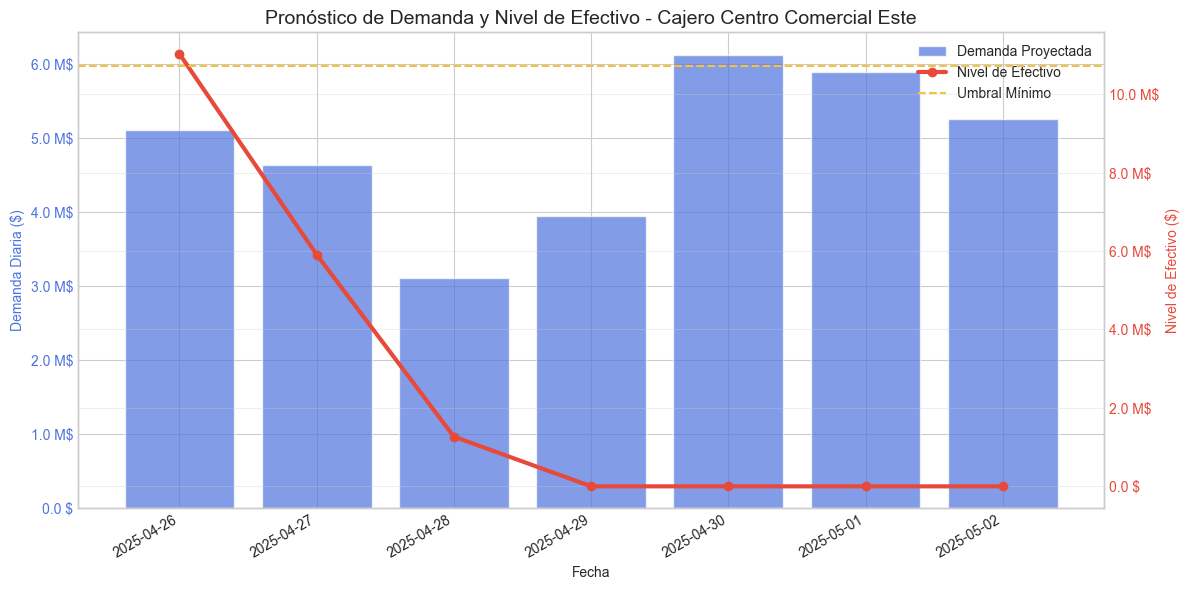

In [8]:
# Visualizar predicciones de demanda para un cajero específico
def plot_demand_forecast(predictions_df, atm_id):
    """
    Visualiza la predicción de demanda y nivel de efectivo para un cajero específico
    """
    # Filtrar predicciones para el cajero seleccionado
    atm_predictions = predictions_df[predictions_df['atm_id'] == atm_id].sort_values('date')
    
    if len(atm_predictions) == 0:
        print(f"No hay predicciones disponibles para el cajero {atm_id}")
        return
    
    # Obtener información del cajero
    atm_info = current_status[current_status['id'] == atm_id].iloc[0]
    
    # Preparar datos para la visualización
    dates = pd.to_datetime(atm_predictions['date'])
    demands = atm_predictions['predicted_demand'].values
    
    # Simular nivel de efectivo proyectado
    cash_levels = [atm_info['current_cash']]
    for demand in demands:
        next_level = max(0, cash_levels[-1] - demand)
        cash_levels.append(next_level)
    
    cash_levels = cash_levels[:-1]  # Eliminar el último que es un día extra
    
    # Crear gráfico
    fig, ax1 = plt.subplots(figsize=(12, 6))
    formatter_millions = EngFormatter(unit="$", places=1) 
    
    # Gráfico de demanda (barras)
    ax1.bar(dates, demands, color=colors['primary'], alpha=0.7, label='Demanda Proyectada')
    ax1.set_xlabel('Fecha')
    ax1.set_ylabel('Demanda Diaria ($)', color=colors['primary'])
    ax1.tick_params(axis='y', labelcolor=colors['primary'])
    ax1.yaxis.set_major_formatter(formatter_millions)
    
    # Gráfico de nivel de efectivo (línea)
    ax2 = ax1.twinx()
    ax2.plot(dates, cash_levels, color=colors['danger'], linewidth=3, marker='o', label='Nivel de Efectivo')
    ax2.axhline(y=atm_info['min_threshold'], color=colors['warning'], linestyle='--', label='Umbral Mínimo')
    ax2.set_ylabel('Nivel de Efectivo ($)', color=colors['danger'])
    ax2.tick_params(axis='y', labelcolor=colors['danger'])
    ax2.yaxis.set_major_formatter(formatter_millions)
    
    # Añadir leyenda
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    # Título y formato
    plt.title(f'Pronóstico de Demanda y Nivel de Efectivo - {atm_info["name"]}', fontsize=14)
    plt.grid(True, alpha=0.3)
    fig.autofmt_xdate()  # Rotar etiquetas de fecha
    plt.tight_layout()
    
    # Mostrar días hasta agotamiento
    days_to_empty = atm_predictions['days_until_empty'].iloc[0]
    priority_level = atm_predictions['priority'].iloc[0]
    priority_text = 'Alta' if priority_level == 3 else 'Media' if priority_level == 2 else 'Baja'
    
    print(f'Cajero: {atm_info["name"]} (ID: {atm_id})')
    print(f'Efectivo actual: ${atm_info["current_cash"]:,.2f}')
    print(f'Umbral mínimo: ${atm_info["min_threshold"]:,.2f}')
    print(f'Días estimados hasta agotamiento: {days_to_empty:.1f}')
    print(f'Prioridad de reabastecimiento: {priority_text}')
    
    plt.show()

# Seleccionar un cajero con alta prioridad para visualizar su pronóstico
if len(high_priority) > 0:
    sample_atm_id = high_priority['atm_id'].iloc[0]
else:
    # Si no hay cajeros de alta prioridad, usar uno de prioridad media
    sample_atm_id = medium_priority['atm_id'].iloc[0] if len(medium_priority) > 0 else tomorrow_predictions['atm_id'].iloc[0]

# Visualizar pronóstico para el cajero seleccionado
plot_demand_forecast(demand_predictions, sample_atm_id)

### Optimización de rutas

En esta sección, generamos rutas optimizadas para el reabastecimiento de cajeros basado en las predicciones de demanda.

In [9]:
# Seleccionar cajeros que requieren reabastecimiento
def select_atms_for_restock(predictions_df, date, min_priority=2):
    """
    Selecciona cajeros que requieren reabastecimiento en la fecha especificada
    basado en su prioridad
    
    Args:
        predictions_df: DataFrame con predicciones
        date: Fecha para la que se seleccionarán cajeros (YYYY-MM-DD)
        min_priority: Prioridad mínima para selección (1=baja, 2=media, 3=alta)
        
    Returns:
        DataFrame con cajeros seleccionados
    """
    # Filtrar predicciones para la fecha especificada
    day_predictions = predictions_df[predictions_df['date'] == date].copy()
    
    # Seleccionar cajeros con prioridad suficiente
    selected_atms = day_predictions[day_predictions['priority'] >= min_priority].copy()
    
    # Verificar restricciones si hay datos disponibles
    if len(restrictions_df) > 0:
        # Obtener día de la semana para la fecha
        date_obj = datetime.strptime(date, '%Y-%m-%d')
        day_of_week = date_obj.weekday()
        
        # Filtrar restricciones para este día
        day_restrictions = restrictions_df[
            (restrictions_df['day_of_week'] == day_of_week) &
            (restrictions_df['restock_allowed'] == False)
        ]
        
        # Excluir cajeros con restricciones
        if len(day_restrictions) > 0:
            restricted_atms = day_restrictions['atm_id'].unique()
            selected_atms = selected_atms[~selected_atms['atm_id'].isin(restricted_atms)].copy()
            print(f"Se excluyeron {len(restricted_atms)} cajeros debido a restricciones para el día {day_of_week}")
    
    # Unir con datos de cajeros para obtener ubicaciones
    if len(selected_atms) > 0:
        selected_atms = pd.merge(
            selected_atms,
            atms_df[['id', 'name', 'latitude', 'longitude', 'location_type', 'max_capacity']],
            left_on='atm_id',
            right_on='id'
        )
        
        # Calcular cantidad a reabastecer (llenar hasta capacidad máxima)
        selected_atms['restock_amount'] = selected_atms.apply(
            lambda row: max(0, row['max_capacity'] - row['current_cash']),
            axis=1
        )
    
    return selected_atms

# Función para limitar número de cajeros si hay demasiados
def limit_atms_for_optimization(atms_to_restock, max_atms=15):
    """Limita el número de cajeros para optimización de rutas"""
    if len(atms_to_restock) > max_atms:
        # Ordenar por prioridad y días hasta agotamiento
        sorted_atms = atms_to_restock.sort_values(
            ['priority', 'days_until_empty'], 
            ascending=[False, True]
        )
        
        # Tomar los N cajeros más importantes
        limited_atms = sorted_atms.head(max_atms)
        
        print(f"Limitando optimización a los {max_atms} cajeros más prioritarios de {len(atms_to_restock)} seleccionados.")
        return limited_atms
    else:
        return atms_to_restock

# Función para calcular matriz de distancias
def calculate_distance_matrix(carrier, atms_to_restock):
    """
    Calcula matriz de distancias entre transportadora y cajeros
    
    Returns:
        matriz de distancias, lista de ubicaciones, lista de nombres
    """
    # Función para calcular distancia Haversine
    def haversine_distance(lat1, lon1, lat2, lon2):
        """Calcula distancia entre dos puntos en km"""
        R = 6371.0  # Radio de la Tierra en km
        
        lat1_rad = math.radians(lat1)
        lon1_rad = math.radians(lon1)
        lat2_rad = math.radians(lat2)
        lon2_rad = math.radians(lon2)
        
        dlon = lon2_rad - lon1_rad
        dlat = lat2_rad - lat1_rad
        
        a = math.sin(dlat / 2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon / 2)**2
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
        distance = R * c
        
        return distance
    
    # Crear lista de ubicaciones
    locations = []
    
    # Añadir transportadora (primer punto = depósito)
    locations.append({
        'id': carrier['id'],
        'name': carrier['name'],
        'lat': carrier['base_latitude'],
        'lon': carrier['base_longitude'],
        'type': 'carrier'
    })
    
    # Añadir cajeros
    for _, atm in atms_to_restock.iterrows():
        locations.append({
            'id': atm['atm_id'],
            'name': atm['name'],
            'lat': atm['latitude'],
            'lon': atm['longitude'],
            'type': 'atm'
        })
    
    # Construir matriz de distancias
    n = len(locations)
    distance_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            if i == j:
                distance_matrix[i][j] = 0
            else:
                distance_matrix[i][j] = haversine_distance(
                    locations[i]['lat'], locations[i]['lon'],
                    locations[j]['lat'], locations[j]['lon']
                )
    
    # Nombres de lugares para referencia
    place_names = [location['name'] for location in locations]
    
    return distance_matrix, locations, place_names

# Funciones para optimización de rutas
def create_data_model(distance_matrix, num_vehicles=1):
    """Prepara datos para el modelo de optimización"""
    data = {}
    # Convertir km a metros y redondear a enteros para mejor funcionamiento
    integer_distances = np.round(distance_matrix * 1000).astype(int)
    data['distance_matrix'] = integer_distances.tolist()
    data['num_vehicles'] = num_vehicles
    data['depot'] = 0  # Índice del depósito (transportadora)
    return data

def solve_vrp(data):
    """Resuelve el problema de enrutamiento de vehículos"""
    # Crear modelo de enrutamiento
    manager = pywrapcp.RoutingIndexManager(
        len(data['distance_matrix']),
        data['num_vehicles'], 
        data['depot']
    )
    routing = pywrapcp.RoutingModel(manager)
    
    # Función de costo (distancia)
    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]
    
    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
    
    # Parámetros de búsqueda
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )
    search_parameters.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
    )
    search_parameters.time_limit.seconds = 30
    
    # Resolver
    solution = routing.SolveWithParameters(search_parameters)
    return manager, routing, solution

def get_solution_routes(manager, routing, solution, place_names):
    """Extrae rutas de la solución del optimizador"""
    routes = []
    
    if not solution:
        return routes
    
    for vehicle_id in range(routing.vehicles()):
        index = routing.Start(vehicle_id)
        route = []
        route_distance = 0
        
        # Si el vehículo está siendo utilizado
        if not routing.IsEnd(solution.Value(routing.NextVar(index))):
            while not routing.IsEnd(index):
                node_index = manager.IndexToNode(index)
                route.append(node_index)
                
                previous_index = index
                index = solution.Value(routing.NextVar(index))
                route_distance += routing.GetArcCostForVehicle(previous_index, index, vehicle_id)
            
            # Añadir nodo final (depósito)
            node_index = manager.IndexToNode(index)
            route.append(node_index)
            
            # Convertir distancia a kilómetros
            route_distance_km = route_distance / 1000.0
            
            routes.append({
                'vehicle_id': vehicle_id,
                'route': route,
                'distance': route_distance_km
            })
    
    return routes

# Función para optimizar rutas para una fecha específica
def optimize_routes_for_date(predictions_df, date, carrier_id=None, min_priority=2):
    """
    Optimiza rutas para reabastecimiento de cajeros en una fecha específica
    
    Args:
        predictions_df: DataFrame con predicciones
        date: Fecha para optimización (YYYY-MM-DD)
        carrier_id: ID de transportadora (opcional, usa la primera si es None)
        min_priority: Prioridad mínima para seleccionar cajeros
        
    Returns:
        Rutas optimizadas, cajeros seleccionados, transportadora
    """
    # Seleccionar cajeros que requieren reabastecimiento
    atms_to_restock = select_atms_for_restock(predictions_df, date, min_priority)
    
    if len(atms_to_restock) == 0:
        print(f"No hay cajeros que requieran reabastecimiento con prioridad >= {min_priority} para {date}")
        return [], pd.DataFrame(), None
    
    # Limitar número de cajeros si hay demasiados
    atms_to_restock = limit_atms_for_optimization(atms_to_restock)
    
    # Seleccionar transportadora
    if carrier_id:
        selected_carrier = carriers_df[carriers_df['id'] == carrier_id].iloc[0]
    else:
        selected_carrier = carriers_df.iloc[0]
    
    print(f"Optimizando rutas para {len(atms_to_restock)} cajeros con la transportadora {selected_carrier['name']}")
    
    # Calcular matriz de distancias
    distance_matrix, locations, place_names = calculate_distance_matrix(selected_carrier, atms_to_restock)
    
    # Determinar número de vehículos (hasta 3 para la demo)
    num_vehicles = min(3, selected_carrier['vehicles'])
    
    # Preparar modelo
    data = create_data_model(distance_matrix, num_vehicles)
    
    # Resolver problema de optimización
    manager, routing, solution = solve_vrp(data)
    
    # Extraer rutas
    if solution:
        routes = get_solution_routes(manager, routing, solution, place_names)
        print(f"Solución encontrada: {len(routes)} rutas generadas")
    else:
        print("No se encontró solución :(")
        routes = []
    
    return routes, atms_to_restock, selected_carrier, locations

# Ejecutar optimización para mañana
tomorrow = (datetime.now().date() + timedelta(days=1)).strftime('%Y-%m-%d')
routes, atms_to_restock, selected_carrier, locations = optimize_routes_for_date(
    demand_predictions, 
    tomorrow, 
    min_priority=2  # Incluir cajeros con prioridad media y alta
)

# Mostrar resumen de rutas
print("\nResumen de rutas optimizadas:")
if routes:
    total_distance = sum(route['distance'] for route in routes)
    total_atms = sum(len(route['route']) - 2 for route in routes)  # -2 para excluir depósito al inicio y final
    
    print(f"Total de rutas: {len(routes)}")
    print(f"Total de cajeros a visitar: {total_atms}")
    print(f"Distancia total: {total_distance:.2f} km")
    
    for i, route in enumerate(routes):
        atms_in_route = len(route['route']) - 2  # -2 para excluir depósito al inicio y final
        print(f"Ruta {i+1}: {atms_in_route} cajeros, {route['distance']:.2f} km")
else:
    print("No se generaron rutas. Intenta con diferentes parámetros o fecha.")

Se excluyeron 19 cajeros debido a restricciones para el día 5
Limitando optimización a los 15 cajeros más prioritarios de 34 seleccionados.
Optimizando rutas para 15 cajeros con la transportadora TransValues Ltda
Solución encontrada: 1 rutas generadas

Resumen de rutas optimizadas:
Total de rutas: 1
Total de cajeros a visitar: 15
Distancia total: 90.86 km
Ruta 1: 15 cajeros, 90.86 km


Visualización de Rutas Optimizadas

In [10]:
# Función para visualizar rutas optimizadas
def visualize_routes(locations, routes, carrier):
    """Visualiza rutas optimizadas en un mapa"""
    from folium.plugins import AntPath
    
    # Crear mapa
    m = folium.Map(
        location=[carrier['base_latitude'], carrier['base_longitude']], 
        zoom_start=12
    )
    
    # Colores para las rutas
    colors = ['blue', 'green', 'red', 'purple', 'orange']
    
    # Añadir transportadora
    folium.Marker(
        location=[carrier['base_latitude'], carrier['base_longitude']],
        popup=f"<b>{carrier['name']}</b><br>Base de operaciones",
        icon=folium.Icon(color='black', icon='truck', prefix='fa')
    ).add_to(m)
    
    # Añadir cada ruta
    for i, route_data in enumerate(routes):
        route = route_data['route']
        color = colors[i % len(colors)]
        
        # Coordenadas de la ruta
        route_coords = []
        for node_idx in route:
            location = locations[node_idx]
            route_coords.append([location['lat'], location['lon']])
        
        # Usar AntPath para mostrar dirección
        AntPath(
            locations=route_coords,
            color=color,
            weight=4,
            opacity=0.8,
            popup=f"Ruta {i+1}: {route_data['distance']:.1f} km",
            delay=1000,
            dash_array=[10, 20],
            pulse_color='#FFF'
        ).add_to(m)
        
        # Añadir marcadores para los cajeros
        for j, node_idx in enumerate(route):
            location = locations[node_idx]
            if location['type'] == 'atm':
                # Añadir marcador numerado
                folium.Marker(
                    location=[location['lat'], location['lon']],
                    popup=f"<b>{location['name']}</b><br>Parada #{j}",
                    icon=folium.Icon(color=color, icon='money-bill-alt', prefix='fa')
                ).add_to(m)
    
    return m

# Mostrar rutas optimizadas
if routes and locations and selected_carrier is not None:
    print("Visualización de rutas optimizadas:")
    route_map = visualize_routes(locations, routes, selected_carrier)
    display(route_map)
else:
    print("No hay rutas para visualizar")


Visualización de rutas optimizadas:


### Análisis de Impacto de Negocio

Evaluamos el impacto esperado de la solución optimizada en las métricas de negocio.

In [11]:
# Función para calcular distancia entre dos puntos geográficos
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calcula la distancia de Haversine entre dos puntos en la Tierra.
    Devuelve la distancia en kilómetros.
    """
    # Radio de la Tierra en km
    R = 6371.0
    
    # Convertir de grados a radianes
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)
    
    # Diferencias
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad
    
    # Fórmula de Haversine
    a = math.sin(dlat / 2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    
    return distance

# Función para calcular KPIs mejorados
def calculate_improved_kpis(status_df, atms_to_restock):
    """Calcula KPIs después de implementar las rutas optimizadas"""
    improved_status = status_df.copy()
    
    # Identificar cajeros que serán reabastecidos
    if len(atms_to_restock) > 0:
        for _, atm in atms_to_restock.iterrows():
            idx = improved_status[improved_status['id'] == atm['atm_id']].index
            if len(idx) > 0:
                # Actualizar efectivo a capacidad máxima
                improved_status.loc[idx, 'current_cash'] = atm['max_capacity']
                improved_status.loc[idx, 'usage_percent'] = 100
                improved_status.loc[idx, 'status'] = 'Normal'
                improved_status.loc[idx, 'days_until_empty'] = improved_status.loc[idx, 'days_until_empty'] * 2  # Aproximación
    
    # Calcular KPIs mejorados
    improved_kpis = {}
    
    # KPI 1: Disponibilidad de efectivo
    total_atms = len(improved_status)
    atms_above_threshold = len(improved_status[improved_status['current_cash'] >= improved_status['min_threshold']])
    improved_kpis['disponibilidad'] = round(atms_above_threshold / total_atms * 100, 2)
    
    # KPI 2: Downtime por agotamiento
    critical_atms = len(improved_status[improved_status['status'] == 'Crítico'])
    improved_kpis['downtime'] = round(critical_atms / total_atms * 100, 2)
    
    # KPI 3: Eficiencia de capital
    improved_kpis['eficiencia_capital'] = round(improved_status['usage_percent'].mean(), 2)
    
    # KPI 4: Días hasta agotamiento
    improved_kpis['dias_hasta_agotamiento'] = round(improved_status['days_until_empty'].mean(), 2)
    
    # KPI 5: Cajeros que requieren atención en los próximos 3 días
    require_attention_soon = len(improved_status[improved_status['days_until_empty'] <= 3])
    improved_kpis['requieren_atencion_pronto'] = require_attention_soon
    
    return improved_kpis

# Calcular impacto en KPIs
if len(atms_to_restock) > 0:
    improved_kpis = calculate_improved_kpis(current_status, atms_to_restock)
    
    # Crear tabla comparativa
    comparison_data = []
    
    for key in current_kpis.keys():
        current_value = current_kpis[key]
        improved_value = improved_kpis[key]
        
        if key == 'disponibilidad':
            metric_name = 'Disponibilidad de Efectivo'
            unit = '%'
            change = improved_value - current_value
            target = '≥ 85%'
            is_good = change > 0
            cumple = improved_value >= 85  # Directamente el valor numérico
        elif key == 'downtime':
            metric_name = 'Downtime por Agotamiento'
            unit = '%'
            change = current_value - improved_value
            target = '≤ 15%'
            is_good = change > 0
            cumple = improved_value <= 15  # Directamente el valor numérico
        elif key == 'eficiencia_capital':
            metric_name = 'Eficiencia de Capital'
            unit = '%'
            change = improved_value - current_value
            target = '40-70%'
            is_good = (40 <= improved_value <= 70 and improved_value > current_value)
            cumple = 40 <= improved_value <= 70  # Directamente el rango
        elif key == 'dias_hasta_agotamiento':
            metric_name = 'Días hasta Agotamiento'
            unit = ' días'  # Espacio añadido para mejor formato
            change = improved_value - current_value
            target = '≥ 5 días'
            is_good = change > 0
            cumple = improved_value >= 5  # Directamente el valor numérico
        elif key == 'requieren_atencion_pronto':
            metric_name = 'Requieren Atención Pronto'
            unit = ' cajeros'  # Espacio añadido para mejor formato
            change = current_value - improved_value
            target_value = int(len(current_status) * 0.2)
            target = f'≤ {target_value}'
            is_good = change > 0
            cumple = improved_value <= target_value  # Directamente el valor numérico
        
        comparison_data.append({
            'Métrica': metric_name,
            'Valor Actual': f"{current_value}{unit}",
            'Valor Mejorado': f"{improved_value}{unit}",
            'Cambio': f"{'+' if is_good else ''}{change:.2f}{unit}",
            'Objetivo': target,
            'Cumple': cumple,  # Ahora usamos la variable calculada específicamente para cada métrica
            'is_good': is_good
        })
    
    # Mostrar tabla comparativa
    comparison_df = pd.DataFrame(comparison_data)
    
    # Crear HTML para tabla de comparación
    html_comparison = """
    <div style="font-family: Arial, sans-serif; margin: 20px 0;">
        <h3 style="margin-bottom: 15px; color: white;">Impacto en Métricas de Negocio</h3>
        <table style="width: 100%; border-collapse: collapse; border: 1px solid #333; color: black;">
            <thead>
                <tr style="background-color: #e0e0e0;">
                    <th style="padding: 12px; text-align: left; border: 1px solid #333; color: black; font-weight: bold;">Métrica</th>
                    <th style="padding: 12px; text-align: center; border: 1px solid #333; color: black; font-weight: bold;">Valor Actual</th>
                    <th style="padding: 12px; text-align: center; border: 1px solid #333; color: black; font-weight: bold;">Valor Mejorado</th>
                    <th style="padding: 12px; text-align: center; border: 1px solid #333; color: black; font-weight: bold;">Cambio</th>
                    <th style="padding: 12px; text-align: center; border: 1px solid #333; color: black; font-weight: bold;">Objetivo</th>
                    <th style="padding: 12px; text-align: center; border: 1px solid #333; color: black; font-weight: bold;">Estado</th>
                </tr>
            </thead>
            <tbody>
    """
    
    for _, row in comparison_df.iterrows():
        # Determinar color para la fila
        bg_color = '#f8f9fc'
        
        # Determinar color para el cambio (más oscuro para mejor contraste)
        change_color = '#0a9b4a' if row['is_good'] else '#d9291c'
        
        # Determinar estado (más oscuro para mejor contraste)
        status_color = '#0a9b4a' if row['Cumple'] else '#d9291c'
        status_text = 'Cumple' if row['Cumple'] else 'No Cumple'
        
        html_comparison += f"""
            <tr style="background-color: {bg_color};">
                <td style="padding: 12px; text-align: left; border: 1px solid #333; color: black;">{row['Métrica']}</td>
                <td style="padding: 12px; text-align: center; border: 1px solid #333; color: black;">{row['Valor Actual']}</td>
                <td style="padding: 12px; text-align: center; border: 1px solid #333; color: black; font-weight: bold;">{row['Valor Mejorado']}</td>
                <td style="padding: 12px; text-align: center; border: 1px solid #333; color: {change_color}; font-weight: bold;">{row['Cambio']}</td>
                <td style="padding: 12px; text-align: center; border: 1px solid #333; color: black;">{row['Objetivo']}</td>
                <td style="padding: 12px; text-align: center; border: 1px solid #333; color: {status_color}; font-weight: bold;">{status_text}</td>
            </tr>
        """

    html_comparison += """
            </tbody>
        </table>
    </div>
    """
    
    display(HTML(html_comparison))
    
    # Calcular ahorro estimado
    if routes:
        # Estimación de costos
        costo_por_km = 5000  # COP por km (ejemplo)
        costo_por_visita = 100000  # COP por visita a cajero (ejemplo)
        
        # Calcular para rutas optimizadas
        distancia_optimizada = sum(route['distance'] for route in routes)
        visitas_optimizadas = sum(len(route['route']) - 2 for route in routes)
        
        # Calcular para enfoque no optimizado (estimación)
        # En un escenario no optimizado, cada cajero podría ser una visita individual desde la base
        distancia_no_optimizada = 0
        for _, atm in atms_to_restock.iterrows():
            # Distancia de ida y vuelta a cada cajero
            dist = haversine_distance(
                selected_carrier['base_latitude'], selected_carrier['base_longitude'],
                atm['latitude'], atm['longitude']
            ) * 2  # ida y vuelta
            distancia_no_optimizada += dist
        
        # Cálculo de costos
        costo_optimizado = (distancia_optimizada * costo_por_km) + (visitas_optimizadas * costo_por_visita)
        costo_no_optimizado = (distancia_no_optimizada * costo_por_km) + (len(atms_to_restock) * costo_por_visita)
        
        # Ahorro
        ahorro_distancia = distancia_no_optimizada - distancia_optimizada
        ahorro_porcentaje = (ahorro_distancia / distancia_no_optimizada * 100) if distancia_no_optimizada > 0 else 0
        ahorro_costo = costo_no_optimizado - costo_optimizado
        
        # Mostrar resultados
        print("\nAnálisis de Ahorro Estimado:")
        print(f"Distancia con optimización: {distancia_optimizada:.2f} km")
        print(f"Distancia sin optimización: {distancia_no_optimizada:.2f} km")
        print(f"Ahorro en distancia: {ahorro_distancia:.2f} km ({ahorro_porcentaje:.2f}%)")
        print(f"Ahorro en costos: ${ahorro_costo:,.2f} COP")
        
        # Proyección mensual
        dias_operacion_mes = 20  # días hábiles al mes
        ahorro_mensual = ahorro_costo * dias_operacion_mes
        print(f"Ahorro mensual proyectado: ${ahorro_mensual:,.2f} COP")
else:
    print("No hay datos suficientes para calcular el impacto en KPIs")

Métrica,Valor Actual,Valor Mejorado,Cambio,Objetivo,Estado
Disponibilidad de Efectivo,97.0%,100.0%,+3.00%,≥ 85%,Cumple
Downtime por Agotamiento,3.0%,0.0%,+3.00%,≤ 15%,Cumple
Eficiencia de Capital,47.67%,60.03%,+12.36%,40-70%,Cumple
Días hasta Agotamiento,5.44 días,5.51 días,+0.07 días,≥ 5 días,Cumple
Requieren Atención Pronto,33 cajeros,33 cajeros,0.00 cajeros,≤ 20,No Cumple



Análisis de Ahorro Estimado:
Distancia con optimización: 90.86 km
Distancia sin optimización: 348.61 km
Ahorro en distancia: 257.74 km (73.94%)
Ahorro en costos: $1,288,719.98 COP
Ahorro mensual proyectado: $25,774,399.51 COP


### Simulador de Escenarios "What-If"
Permitimos al usuario explorar diferentes escenarios ajustando parámetros clave.

In [12]:
# Función para simular diferentes escenarios
def simulate_scenario(num_vehicles=None, min_priority=None, carrier_id=None):
    """
    Simula un escenario alternativo cambiando parámetros clave
    
    Args:
        num_vehicles: Número de vehículos a utilizar
        min_priority: Prioridad mínima para selección de cajeros
        carrier_id: ID de transportadora a utilizar
        
    Returns:
        Rutas optimizadas, atms seleccionados, transportadora
    """
    # Usar valores por defecto si no se especifican
    min_priority = min_priority if min_priority is not None else 2
    
    # Seleccionar transportadora
    if carrier_id:
        selected_carrier = carriers_df[carriers_df['id'] == carrier_id]
        if len(selected_carrier) == 0:
            print(f"Transportadora con ID {carrier_id} no encontrada. Usando la primera.")
            selected_carrier = carriers_df.iloc[0]
        else:
            selected_carrier = selected_carrier.iloc[0]
    else:
        selected_carrier = carriers_df.iloc[0]
    
    # Obtener predicciones para mañana
    tomorrow = (datetime.now().date() + timedelta(days=1)).strftime('%Y-%m-%d')
    
    # Seleccionar cajeros que requieren reabastecimiento
    atms_to_restock = select_atms_for_restock(demand_predictions, tomorrow, min_priority)
    
    if len(atms_to_restock) == 0:
        print(f"No hay cajeros que requieran reabastecimiento con prioridad >= {min_priority}")
        return [], pd.DataFrame(), selected_carrier, None
    
    # Limitar número de cajeros
    atms_to_restock = limit_atms_for_optimization(atms_to_restock)
    
    # Calcular matriz de distancias
    distance_matrix, locations, place_names = calculate_distance_matrix(selected_carrier, atms_to_restock)
    
    # Determinar número de vehículos
    if num_vehicles is not None:
        num_vehicles = min(num_vehicles, selected_carrier['vehicles'])
    else:
        num_vehicles = min(3, selected_carrier['vehicles'])  # Default
    
    print(f"Simulando escenario con {num_vehicles} vehículos, {len(atms_to_restock)} cajeros y prioridad mínima {min_priority}")
    
    # Preparar modelo
    data = create_data_model(distance_matrix, num_vehicles)
    
    # Resolver problema
    manager, routing, solution = solve_vrp(data)
    
    # Extraer rutas
    if solution:
        routes = get_solution_routes(manager, routing, solution, place_names)
        print(f"Solución encontrada: {len(routes)} rutas generadas")
    else:
        print("No se encontró solución para este escenario")
        routes = []
    
    return routes, atms_to_restock, selected_carrier, locations

# Ejemplo de simulación de escenario alternativo
print("Simulación de escenario alternativo: Usando menos vehículos y mayor prioridad")
alt_routes, alt_atms, alt_carrier, alt_locations = simulate_scenario(
    num_vehicles=2,  # Limitar a 2 vehículos
    min_priority=3   # Solo cajeros de alta prioridad
)

# Mostrar resultados del escenario alternativo
if alt_routes:
    print("\nResumen del escenario alternativo:")
    total_distance = sum(route['distance'] for route in alt_routes)
    total_atms = sum(len(route['route']) - 2 for route in alt_routes)
    
    print(f"Total de rutas: {len(alt_routes)}")
    print(f"Total de cajeros a visitar: {total_atms}")
    print(f"Distancia total: {total_distance:.2f} km")
    
    # Mostrar mapa
    alt_map = visualize_routes(alt_locations, alt_routes, alt_carrier)
    display(alt_map)
    
    # Comparar con escenario base
    if routes:
        base_distance = sum(route['distance'] for route in routes)
        base_atms = sum(len(route['route']) - 2 for route in routes)
        
        print("\nComparación con escenario base:")
        print(f"Cajeros visitados: {total_atms} vs {base_atms} (base)")
        print(f"Distancia: {total_distance:.2f} km vs {base_distance:.2f} km (base)")
        print(f"Diferencia: {total_distance - base_distance:.2f} km ({(total_distance - base_distance) / base_distance * 100:.2f}%)")
else:
    print("No se pudieron generar rutas para el escenario alternativo")

Simulación de escenario alternativo: Usando menos vehículos y mayor prioridad
Se excluyeron 19 cajeros debido a restricciones para el día 5
Simulando escenario con 2 vehículos, 15 cajeros y prioridad mínima 3
Solución encontrada: 1 rutas generadas

Resumen del escenario alternativo:
Total de rutas: 1
Total de cajeros a visitar: 15
Distancia total: 90.86 km



Comparación con escenario base:
Cajeros visitados: 15 vs 15 (base)
Distancia: 90.86 km vs 90.86 km (base)
Diferencia: 0.00 km (0.00%)


### Recomendaciones y Conclusiones
Presentamos las recomendaciones y conclusiones finales basadas en los resultados de la optimización.

In [13]:
# Crear resumen de recomendaciones con espaciado optimizado
html_recommendations = """
<div style="font-family: Arial, sans-serif; margin: 20px 0; background-color: white; padding: 20px; border-radius: 10px; box-shadow: 0 4px 8px rgba(0,0,0,0.1);">
    <h2 style="color: #4e73df; margin-bottom: 15px;">Conclusiones y Recomendaciones</h2>
    <h3 style="color: #5a5c69; margin-top: 15px; margin-bottom: 10px;">Resumen de Hallazgos</h3>
    <ul style="line-height: 1.5; color: black; margin-top: 5px; padding-left: 20px;">
"""

# Añadir hallazgos sobre estado actual
critical_count = len(current_status[current_status['status'] == 'Crítico'])
warning_count = len(current_status[current_status['status'] == 'Advertencia'])
html_recommendations += f"""
        <li>Actualmente hay <b>{critical_count} cajeros en estado crítico</b> y <b>{warning_count} en estado de advertencia</b> que requieren atención.</li>
        <li>La disponibilidad de efectivo actual es del <b>{current_kpis['disponibilidad']}%</b>, por encima del objetivo del 85%.</li>
"""

# Añadir hallazgos sobre optimización si hay rutas
if routes:
    total_distance = sum(route['distance'] for route in routes)
    total_atms = sum(len(route['route']) - 2 for route in routes)
    
    # Verificar si tenemos los datos de ahorro calculados
    ahorro_info = ""
    try:
        # Intentar calcular el ahorro mensual si no existe
        if 'ahorro_mensual' not in locals() and 'ahorro_mensual' not in globals():
            # Cálculos básicos de ahorro para la demo
            costo_por_km = 5000  # COP por km (ejemplo)
            ahorro_mensual = total_distance * costo_por_km * 20  # 20 días al mes
        
        ahorro_info = f"""<li>El ahorro estimado con la optimización de rutas es de aproximadamente <b>${ahorro_mensual:,.0f} COP mensuales</b>.</li>"""
    except:
        # Si no se puede calcular, omitir esta información
        ahorro_info = """<li>La optimización de rutas proporciona un ahorro significativo en costos operativos.</li>"""
    
    html_recommendations += f"""
        <li>Se han generado <b>{len(routes)} rutas optimizadas</b> para atender <b>{total_atms} cajeros</b> con una distancia total de <b>{total_distance:.1f} km</b>.</li>
        <li>La implementación de las rutas optimizadas incrementaría la disponibilidad de efectivo al <b>{improved_kpis['disponibilidad']}%</b>, cumpliendo con el objetivo.</li>
        {ahorro_info}"""

html_recommendations += """
    </ul>
    <h3 style="color: #5a5c69; margin-top: 15px; margin-bottom: 10px;">Recomendaciones</h3>
    <ul style="line-height: 1.5; color: black; margin-top: 5px; padding-left: 20px;">
        <li><b>Implementar reabastecimiento inmediato</b> para los cajeros en estado crítico, priorizando aquellos con mayor demanda.</li>
        <li><b>Ajustar los umbrales mínimos</b> de efectivo en cajeros con alta rotación para prevenir agotamientos.</li>
        <li><b>Implementar la solución de optimización de rutas</b> para maximizar la eficiencia logística y reducir costos operacionales.</li>
        <li><b>Establecer monitoreo continuo</b> de los patrones de demanda para ajustar las predicciones y mejorar la precisión.</li>
        <li><b>Revisar restricciones horarias</b> para identificar oportunidades de flexibilización en cajeros de alta prioridad.</li>
    </ul>
    <h3 style="color: #5a5c69; margin-top: 15px; margin-bottom: 10px;">Próximos Pasos</h3>
    <ol style="line-height: 1.5; color: black; margin-top: 5px; padding-left: 20px;">
        <li>Refinar el modelo predictivo con datos históricos adicionales para aumentar la precisión al objetivo del 87%.</li>
        <li>Integrar datos externos como eventos especiales, días de pago y variables económicas para mejorar las predicciones.</li>
        <li>Desarrollar una interfaz de usuario completa para operaciones diarias del Centro de Efectivo.</li>
        <li>Implementar integración con sistemas de las transportadoras para automatizar la asignación de rutas.</li>
        <li>Establecer un sistema de monitoreo y evaluación continua para medir el impacto real de la solución.</li>
    </ol>
</div>
"""

In [14]:
# Mostrar recomendaciones
display(HTML(html_recommendations))